<a href="https://colab.research.google.com/github/madziejm/1e100-ibu/blob/master/1e100ibu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminary

#### Dependencies

In [12]:
import torch
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'dev = {dev}')

dev = cpu


In [1]:
!pip install --quiet icecream
from icecream import ic

In [2]:
# !pip install --quiet -Iv torch==1.10.1
# !pip install --quiet -Iv torchtext==0.11.1

## Dataset representation

In [3]:
!pip install 'spacy<3.3.0,>=3.2.0' --quiet
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 69.0 MB/s 
     |████████████████████████████████| 451 kB 76.4 MB/s 
     |████████████████████████████████| 628 kB 72.6 MB/s 
     |████████████████████████████████| 10.1 MB 40.0 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
     |████████████████████████████████| 13.9 MB 5.3 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
!pip show spacy | egrep Version
# we want SpaCy 3
!pip show torch | egrep Version
!pip show torchtext | egrep Version

Version: 3.2.1
Version: 1.10.0+cu111
Version: 0.11.0


#### review example

In [5]:
#     """
#     beer/name: John Harvards Simcoe IPA
#     beer/beerId: 63836
#     beer/brewerId: 8481
#     beer/ABV: 5.4
#     beer/style: India Pale Ale &#40;IPA&#41;
#     review/appearance: 4/5
#     review/aroma: 6/10
#     review/palate: 3/5
#     review/taste: 6/10
#     review/overall: 13/20
#     review/time: 1157587200
#     review/profileName: hopdog
#     review/text: On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.
#     """

#### dataset representation

In [55]:
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch

class RateBeerReviews(torch.utils.data.Dataset):
    def __init__(self, filepath='/content/SNAP-Ratebeer.txt', reviews_max=float('inf')):
        self.aspects = ['appearance', 'aroma', 'palate', 'taste', 'overall']
        self.aspect_count = len(self.aspects)
        self.aspect_max = [5, 10, 5, 10, 20]
        self._aspect_ratings = [ [] for _ in self.aspects ]
        self._texts = []
        self.unkn_tok = "<unk>" # unknown/out of vocabulary token
        self._len = 0
        self._fetch_data(filepath, reviews_max)
        self._post_process(max_word_count=20000) # 20K words should be okay

    def _fetch_data(self, filepath, reviews_max):
        with io.open(filepath, encoding='utf-8') as f:
            for line in tqdm(f, total=(40938282 if reviews_max == float('inf') else reviews_max * 14), desc='Reading data'):
                if line == '\n': # separator
                    self._len += 1
                    if reviews_max <= self._len:
                        break
                elif line.startswith('review/appearance: '):
                    line = line[len('review/appearance: '):]
                    self._aspect_ratings[0].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/aroma: '):
                    line = line[len('review/aroma: '):]
                    self._aspect_ratings[1].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/palate: '):
                    line = line[len('review/palate: '):]
                    self._aspect_ratings[2].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/taste: '):
                    line = line[len('review/taste: '):]
                    self._aspect_ratings[3].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/overall: '):
                    line = line[len('review/overall: '):]
                    self._aspect_ratings[4].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/text: '):
                    line = line[len('review/text: '):]
                    if line.startswith('UPDATED:'):
                        line = line[len("UPDATED: APR 29, 2008"):] # drop prefix
                    line = re.sub('~', ' ', line.strip()) # remove whitespace incl. trailing newline and tildes that can be found in data for some reason
                    if line:
                        self._texts.append(line)
                    else: # some reviews do not have associated text; unwind (remove) their ratings for each aspect
                        for aspect_ratings in self._aspect_ratings:
                            aspect_ratings.pop()
                        self._len -= 1

    def _post_process(self, min_word_freq=None, max_word_count=None):
        assert (min_word_freq is not None) ^ bool(max_word_count is not None), "provide one of min_word_freq and max_word_count"
        nlp = spacy.util.get_lang_class('en')()
        nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
        nlp.Defaults.stop_words |= { '-', '+'}
        nlp.Defaults.stop_words -= {'mostly', 'whole', 'indeed', 'quite', 'ever', 'nothing', 'perhaps', 'not', 'no', 'only', 'well', 'really', 'except'}
        print("Spacy pipe (tokenization&sentence split)..")
        gc.collect() # force garbage collection
        self._texts = [tuple(list(tok.lower_ for tok in sent if not tok.is_stop and not tok.is_punct and not tok.is_space and len(tok) > 2) for sent in doc.sents if 0 != len(sent)) for doc in nlp.pipe(self._texts)]
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Building vocab (word-id mapping)..")
        gc.collect() # force garbage collection
        sent_gen = (sent for text in self._texts for sent in text)
        if min_word_freq:
            self.vocab = build_vocab_from_iterator(sent_gen, specials=[self.unkn_tok], min_word_freq=5)
        else:
            words = Counter()
            for tokens in sent_gen:
                words.update(tokens)
            words = [word for word, freq in words.most_common(max_word_count)] # list sorted by frequency yikees
            self.vocab = Vocab(VocabPybind(words, None))
        self.vocab.insert_token(self.unkn_tok, 0)
        self.vocab.set_default_index(self.vocab[self.unkn_tok]) # set index for out-of-vocabulary words
        print("Mapping words to ids..")
        gc.collect() # force garbage collection
        self._texts = [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in self._texts]
        gc.collect() # force garbage collection

    def __getitem__(self, i):
        # # 1 # python
        # sentences = tuple(sent for sent in self._texts[i])
        # ratings = tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count))
        # 2 # tensor
        sentences = tuple(torch.LongTensor(sent) for sent in self._texts[i])
        ratings = torch.LongTensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        # # 3 # dev
        # sentences = tuple(torch.tensor(sent) for sent in self._texts[i])
        # ratings = torch.tensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        return (sentences, ratings)

    def __len__(self):
        return self._len

If you want to read dataset from dataset file, set FETCH_RATEBEER to true in the cell below and RECREATE_PICKLE to True. If you left them untouched, it'lle be read from serialized `RateBeerReviews` class object instead of parsing text file.

In [7]:
%%bash

export FETCH_RATEBEER=false
if [ "$FETCH_RATEBEER" = true ] && [ -e $RATEBEER_FILE ]
then # original dataset
    export RATEBEER_FILE='/content/SNAP-Ratebeer.txt'
    gdown --id '12tEEYQcHZtg5aWyfIiWWVIDAJNT-5d_T' # https://drive.google.com/file/d/12tEEYQcHZtg5aWyfIiWWVIDAJNT-5d_T/view?usp=sharing
    echo "Dataset head (trailing newline makes entry end): "
    head -n 16 $RATEBEER_FILE
    iconv -f ISO-8859-1 -t UTF-8 $RATEBEER_FILE -o {RATEBEER_FILE}.new && mv {RATEBEER_FILE}.new $RATEBEER_FILE
else # pickle
    gdown --id '1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_' # https://drive.google.com/file/d/1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_/view?usp=sharing  # 20K words dataset
    # gdown --id '1ebDMDlOxtFh8B5i8lajR7q3kq-0hM02j' # https://drive.google.com/file/d/1ebDMDlOxtFh8B5i8lajR7q3kq-0hM02j/view?usp=sharing # min frequency 5 words dataset
fi

Downloading...
From: https://drive.google.com/uc?id=1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_
To: /content/ratebeer-20K-vocab.pickle
100%|##########| 393M/393M [00:03<00:00, 104MB/s]


In [8]:
import pickle # serialize lib
from google.colab import drive

drive.mount('/drive')

# DATASET_PICKLE='/content/ratebeer.pickle'
DATASET_PICKLE='/content/ratebeer-20K-vocab.pickle'
RECREATE_PICKLE = False

if RECREATE_PICKLE:
    rb = RateBeerReviews()
    with open(DATASET_PICKLE, 'wb') as f:
        print('Dumping..')
        torch.save(rb, f)
else:
    with open(DATASET_PICKLE, 'rb') as f:
        rb = torch.load(f)

Mounted at /drive


In [9]:
# word ID-s count and 1K of least common words
print(len(rb.vocab.get_itos()))
print(rb.vocab.get_itos()[-1000:])

20001
['tractor', 'syd', 'chiefly', 'defiant', 'stripper', 'val', 'bierhaus', 'eyeball', 'sporatic', 'deviate', 'grapenuts', 'beervana', 'tarness', 'lenny', 'phenomenon', 'reek', 'usualy', 'bernard', 'barbecued', 'fruitbeer', 'enjoyit', 'rive', 'sas', 'flavorable', 'ecstatic', 'leopoldstoch', 'soulless', 'allagashs', 'mikrobryggeri', 'disgusted', 'heine', 'covey', 'respectively', 'scout', 'emitting', 'flemdawg', 'atom', 'brightens', 'pch', 'www.bierzwerg.de', 'oakwood', 'flagged', 'collor', 'rbnag-11', 'belter', 'ecstasy', 'deem', 'gust', 'creamyish', 'opq', 'fruti', 'accompagne', 'zunge', 'sinful', 'prunish', 'ingrediants', 'refill', 'rug', 'alc%', 'blase', 'paramount', 'oldrtybastrd', 'fininsh', 'sofort', 'sazz', 'echoing', 'prospect', 'contributor', 'crazily', 'rogueone', 'beer_hawk', 'presenza', 'overlain', 'hinteren', 'spur', 'suspicions', 'glendale', 'renowned', 'hover', '09/08/2008', 'flashback', 'degraded', 'vegetabley', 'sunburst', 'snug', 'beneficial', 'linkery', 'mtn', 'doub

### Training (implementation of $(1)$)

In [94]:
from torch.utils.data import random_split, DataLoader
import datetime
from scipy.optimize import linear_sum_assignment
from more_itertools import grouper

# for wordclouds
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

class Model():
    def __init__(self, dataset):
        self.ds = dataset
        self.init_weights()

    def init_weights(self):
        word_count = len(self.ds.vocab.get_itos())
        self.theta = torch.rand((word_count, self.ds.aspect_count), device=dev)
        # scale to [-0.1, 0.0], as we enforce this weight to 1.0 for some words later on
        # self.theta = self.theta * -0.1
        # scale to [0.0, 0.9], as we enforce this weight to 1.0 for some words later on
        self.theta = self.theta * 0.9
        # enforce 1 initialization on aspect name (page 4)
        aspect_ids = self.ds.vocab.lookup_indices(self.ds.aspects)
        for aspect_idx, aspect_id in enumerate(aspect_ids):
            # ic(aspect_id)
            # ic(aspect_idx)
            # ic(self.ds.vocab.get_itos()[aspect_id])
            self.theta[aspect_id, aspect_idx] = 1
        self.theta.requires_grad_()

        # introduce separate phi for each aspect
        self.phis = [torch.rand((word_count, self.ds.aspect_max[i])).to(dev) for i in range(self.ds.aspect_count)]
        # self.phis = [torch.zeros((word_count, self.ds.aspect_max[i]), device=dev) for i in range(self.ds.aspect_count)]
        # # normalize that sum across all words is 1 for a given aspect (eq. 7) # do not normalize as for now
        # self.phis = [phi / phi.sum(dim=0) for phi in self.phis]
        for phi in self.phis: phi.requires_grad_()
    
    def word_clouds(self):
        words = self.ds.vocab.get_itos()
        fig = plt.figure(figsize=(21, 5))
        i = 0

        for aspect in range(self.ds.aspect_count):
            print()
            aspect_name = self.ds.aspects[aspect]
            print(aspect_name)
            atheta = self.theta[:, aspect].tolist()
            zipped = list(zip(words, atheta))
            sorted_zip = sorted(zipped, reverse=True, key=lambda x: x[1])[:50]
            print(*[(word, '%s' % float('%.3g' % weight)) for (word, weight) in sorted_zip])

            wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black')
            wc.generate_from_frequencies(dict(zipped))

            fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + 1)
            # ic(i * (max(self.ds.aspect_max) + 1) + 1)
            plt.imshow(wc)
            plt.title(aspect_name + " Theta", fontsize=2)
            # plt.show(wc, interpolation="bilinear")
            plt.axis("off")

            for rating in range(self.ds.aspect_max[aspect]):
                aphi = self.phis[aspect][:, rating].tolist()

                zipped = list(zip(words, aphi))
                sorted_zip = sorted(zipped, reverse=True, key=lambda x: x[1])[:50]
                wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black')
                wc.generate_from_frequencies(dict(zipped))
                fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + rating + 2)

                # ic (i * (max(self.ds.aspect_max) + 1) + rating + 2)

                plt.imshow(wc)
                plt.title(aspect_name + " Phi " + str(rating + 1), fontsize=2)
                # plt.show(wc, interpolation="bilinear")
                plt.axis("off")

            i += 1
        plt.savefig("clouds.png", dpi=300)
        plt.show(block=True)

    def rev_words_thetas(self, rev_sens_ids):
        """
        TODO comment sentence_aspects_likelihood_theta
        """
        return [self.theta[sen_ids] for sen_ids in rev_sens_ids]

    def rev_words_phis(self, rev_sens_ids):
        """
        TODO comment sentence_aspects_likelihood_phi
        """
        return [[self.phis[aspect_idx][sen_ids, :] for aspect_idx in range(self.ds.aspect_count)] for sen_ids in rev_sens_ids]
    
    def dump_weights(self, dest_dir='/drive/MyDrive/Colab Notebooks/1e100ibu/saves/'):
        weights = {'phis': self.phis, 'theta': self.theta}
        torch.save(weights,  f'{dest_dir}{datetime.datetime.now()}')

    def load_weights(self, src_path):
        weights = torch.load(src_path, map_location=torch.device(dev))
        self.theta = weights['theta']
        self.phis  = weights['phis']
    
    def _linear_assignement(self, costs):
        # for nll we want to minimize
        return linear_sum_assignment(costs, maximize=False)

    def ided_review_forward(self, rev_sents_ids, review_aspects_scores):
        rev_thetas = self.rev_words_thetas(rev_sents_ids)
        rev_phis   = self.rev_words_phis(rev_sents_ids)
        res_sents_scores = torch.stack(
            [
            rev_thetas[j].sum(dim=0) + torch.tensor(tuple(rev_phis[j][a][:, review_aspects_scores[a]].sum() for a in range(self.ds.aspect_count))).to(dev) # 1 x aspect count
            for j in range(len(rev_sents_ids))
            ],
        ) # sent count x aspect count
        sents_aspect_preds_max = torch.argmax(res_sents_scores, dim=1)
        # row_ind, col_ind = self._linear_assignement(costs=res_sents_scores.detach().cpu().numpy())
        sents_aspect_preds_linear = sents_aspect_preds_max
        
        # sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
        # ll_loses = []
        for j in range(len(rev_sents_ids)):
            # if not rev_sents_ids[j]: # ignore empty sentences if they are list, but not tensor (unused)
            if 0 == rev_sents_ids[j].numel(): # ignore empty sentences
                continue
            sen_thetas = rev_thetas[j]
            sen_phis   = rev_phis[j]

            # (most likely) aspect assignment (5)
            aspect_pred = sents_aspect_preds_linear[j]

            # sentence likelihood (6)
            aspect_rating = review_aspects_scores[aspect_pred]
            theta_score_ll = sen_thetas[:, aspect_pred].sum()
            phi_score_ll = sen_phis[aspect_pred][:, aspect_rating].sum()

            ll = torch.log(theta_score_ll + phi_score_ll)
            # sentence_ll_losses.append(-ll) TODO removed and not tested
        
        # reviev_sents_ids
        return sents_aspect_preds_linear

    def train(self, epoch_count=10, optim='sgd'):

        train_size = int(0.8 * len(self.ds))
        # train_size = 1000 # use the latter; this is for debuggin' only
        test_size = len(self.ds) - train_size

        params = (
            self.theta,
            *self.phis
        )
        lr = 0.001
        # lr = sum(self.ds.aspect_max) * 0.01 / train_size # for whole batch iteration
        weight_decay = 1
        momentum = 0.9
        if optim == 'sgd':
            self._optim = torch.optim.SGD(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                momentum=momentum
            )
        elif optim == 'adam': # do not use Adam, weights go to NaN with it for some reason
            self._optim = torch.optim.Adam(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                betas=(momentum, 0.999) # the first is params momentum, second RMSProp momentum (for now fix to 0.999 which is default Pytorch value)
            )
        else:
            assert False
        self._sched = torch.optim.lr_scheduler.StepLR(self._optim, step_size=1, gamma=0.95)

        generator = torch.Generator().manual_seed(42) # let's fix RNG seed for now

        self.train_ds, self.test_ds = random_split(self.ds, [train_size, test_size], generator=generator)
    
        torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=160, profile=None, sci_mode=None)

        train_loader = DataLoader(self.train_ds, batch_size=100, shuffle=True, generator=generator, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/42654
        self.nll_hist = []
        try:
            for epoch in range(epoch_count):
                ic(epoch, epoch_count)

                for i, batch in enumerate(tqdm(train_loader)):
                    batch_nlls = []
                    for (rev_sents_ids, review_aspects_scores) in batch:
                        # for sent_ids in rev_sents_ids: sent_ids.to(dev)
                        rev_thetas = self.rev_words_thetas(rev_sents_ids)
                        rev_phis   = self.rev_words_phis(rev_sents_ids)

                        res_sents_scores = torch.stack(
                            [
                            rev_thetas[j].sum(dim=0) + torch.tensor(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count)), device=dev) # 1 x aspect count
                            for j in range(len(rev_sents_ids))
                            ],
                        ) # sent count x aspect count

                        denoms = torch.logsumexp(res_sents_scores, dim=1)[:, None]
                        assert(denoms.shape == (len(rev_sents_ids), 1))

                        res_sents_scores = -res_sents_scores + denoms

                        sents_aspect_preds_max = torch.argmin(res_sents_scores, dim=1)
                        row_ind, col_ind = self._linear_assignement(costs=res_sents_scores.detach().cpu().numpy())
                        sents_aspect_preds_linear = sents_aspect_preds_max
                        
                        # (most likely) aspect assignments (5)
                        sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
                        
                        # sentence likelihood (6)
                        batch_nlls.append(res_sents_scores.take_along_dim(sents_aspect_preds_linear[:, None], dim=1).sum())

                    batch_nll = torch.stack(batch_nlls).sum()
                    self._optim.zero_grad(set_to_none=True)
                    if 0 == i % 400:
                        ic(batch_nll)
                        self.nll_hist.append(batch_nll.cpu().detach())
                        self.dump_weights()
                    batch_nll.backward()

                    self._optim.step()
                self._sched.step()
                    
        except KeyboardInterrupt:
            print('Interrupted.')
        except Exception as e:
            # ic(nll)
            ic(len(batch_nlls))
            ic(denoms)
            ic(rev_sents_ids)
            # ic(sen_phis)
            # ic(sen_thetas)
            ic(theta_score_ll + phi_score_ll)
            ic(theta_score_ll)
            ic(phi_score_ll)
            ic(batch_nll)
            ic(denoms.size())
            ic((len(rev_sents_ids),))
            ic(denoms.size() == (len(rev_sents_ids),))
            raise e


In [95]:
model = Model(rb)


appearance
('appearance', '1.0') ('sahara', '0.9') ('perfumey', '0.9') ('tte', '0.9') ('apologies', '0.9') ('incident', '0.9') ('gun', '0.9') ('achete', '0.9') ('georgia', '0.9') ('breckenridge', '0.9') ('skumhoved', '0.899') ('foiled', '0.899') ('line', '0.899') ('fanfare', '0.899') ('porous', '0.899') ('strands', '0.899') ('olivier_mtl', '0.899') ('yeaty', '0.899') ('1986', '0.899') ('pungency', '0.899') ('venturing', '0.899') ('explodes', '0.899') ('ericandersnavy', '0.899') ('resulting', '0.899') ('mojo', '0.899') ('sorachi', '0.899') ('exotic', '0.899') ('association', '0.899') ('roasy', '0.899') ('colour', '0.899') ('commercially', '0.899') ('jst', '0.899') ('imagine', '0.899') ('thursday', '0.899') ('brea', '0.899') ('shoots', '0.899') ('suggested', '0.899') ('doc', '0.898') ('pretend', '0.898') ('bruges', '0.898') ('vice', '0.898') ('lingonberries', '0.898') ('fantastisk', '0.898') ('construction', '0.898') ('yeast-', '0.898') ('lgith', '0.898') ('demonstrative', '0.898') ('-n

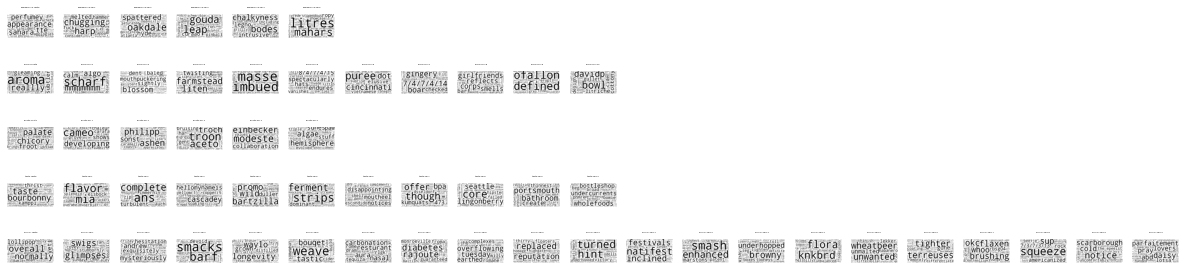

In [96]:
model.ds.aspect_max = [5, 10, 5, 10, 20]

model.word_clouds()

In [29]:
model.train()


ic| epoch: 0, epoch_count: 10


  0%|          | 0/23353 [00:00<?, ?it/s]

ic| batch_nll: tensor(500.1972, grad_fn=<SumBackward0>)


Interrupted.


In [ ]:
model.load_weights('/drive/MyDrive/Colab Notebooks/1e100ibu/saves/2022-01-17 11_29_14.050262')

FileNotFoundError: ignored

In [ ]:
itos = model.ds.vocab.get_itos()

In [ ]:
for i, (rev_sents_ids, review_aspects_scores) in enumerate(model.test_ds):
    if i > 9:
        break
    print(list(zip(model.ds.aspects, review_aspects_scores.tolist())))
    for sen_ids in rev_sents_ids:
        print([itos[idx] for idx in sen_ids])
        # print(model.ds.vocab.lookup_indices(.tolist()))
    print(rev_sents_ids, review_aspects_scores)
    aspects = model.ided_review_forward(rev_sents_ids, review_aspects_scores)
    print([model.ds.aspects[aspect] for aspect in aspects])
    print()

[('appearance', 4), ('aroma', 7), ('palate', 3), ('taste', 8), ('overall', 15)]
['<unk>', 'world', 'live', '<unk>', '2008']
['amber', 'beer', 'good', 'head']
['aroma', 'malty', 'rich', 'flavour', 'rich', 'vinous', 'malty']
['overall', 'nice', 'vinous', 'rich', 'beer']
(tensor([   0,  602, 1256,    0,  490]), tensor([27,  5, 14,  1]), tensor([  2,  28, 102,  62, 102, 474,  28]), tensor([ 86,  11, 474, 102,   5])) tensor([ 4,  7,  3,  8, 15])
['overall', 'aroma', 'palate', 'overall']

[('appearance', 3), ('aroma', 8), ('palate', 4), ('taste', 8), ('overall', 16)]
['pours', 'light', 'amber']
['great', 'american', 'hop', 'aroma', 'tones', 'pine', 'grapefruit', 'tangerine', 'flowers', 'apricot']
['sweet', 'malt', 'background']
['subtle', 'tropical', 'tones', 'present']
['spicy', 'hop', 'flavour', 'tones', 'grapefruit', 'pine', 'apricot', 'tangerine']
['fruity']
['discrete', 'malty', 'background']
['light', 'sweet', 'medium', 'bitter']
['medium', 'dry']
['medium', 'bodied']
['favourite', 'ip

In [ ]:
# danger
# model.ds.vocab.lookup_indices([0])

## Word clouds

In [23]:
pip install wordcloud


appearance
('appearance', '1.0') ('cisco', '0.9') ('oxidised', '0.9') ('maltbase', '0.9') ('fumes', '0.9') ('longtemps', '0.9') ('ambroise', '0.9') ('protein', '0.9') ('-this', '0.9') ('piney', '0.9') ('gleichzeitig', '0.9') ('squared', '0.9') ('nol', '0.9') ('odorless', '0.9') ('store', '0.899') ('0.355l', '0.899') ('gering', '0.899') ('marstons', '0.899') ('volgon', '0.899') ('mccoys', '0.899') ('creme', '0.899') ('box', '0.899') ('ahead', '0.899') ('perplexing', '0.899') ('solar', '0.899') ('honeyish', '0.899') ('championship', '0.899') ('scores', '0.899') ('streak', '0.899') ('jonathan', '0.899') ('clara', '0.899') ('immaculate', '0.899') ('outrageous', '0.899') ('welll', '0.899') ('hazyness', '0.899') ('effects', '0.899') ('4/10', '0.898') ('offers', '0.898') ('shortlasting', '0.898') ('meidum', '0.898') ('sly', '0.898') ('aloe', '0.898') ('board', '0.898') ('kolsh', '0.898') ('bittnerness', '0.898') ('tne', '0.898') ('amid', '0.898') ('apropos', '0.898') ('newspaper', '0.898') (

ic| aspect: 0


AttributeError: ignored

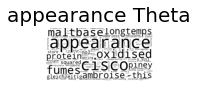

In [100]:
def dupa(self):
    words = self.ds.vocab.get_itos()
    fig = plt.figure(figsize=(21, 5))
    i = 0

    for aspect in range(self.ds.aspect_count):
        print()
        aspect_name = self.ds.aspects[aspect]
        print(aspect_name)
        atheta = self.theta[:, aspect].tolist()
        zipped = list(zip(words, atheta))
        sorted_zip = sorted(zipped, reverse=True, key=lambda x: x[1])[:50]
        print(*[(word, '%s' % float('%.3g' % weight)) for (word, weight) in sorted_zip])

        wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black')
        wc.generate_from_frequencies(dict(zipped))

        fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + 1)
        # ic(i * (max(self.ds.aspect_max) + 1) + 1)
        plt.imshow(wc)
        plt.title(aspect_name + " Theta", fontsize=2)
        # plt.show(wc, interpolation="bilinear")
        plt.axis("off")

        for rating in range(self.ds.aspect_max[aspect]):
            aphi = self.phis[aspect][:, rating].tolist()

            zipped = list(zip(words, aphi))
            sorted_zip = sorted(zipped, reverse=True, key=lambda x: x[1])[:50]
            wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black')
            wc.generate_from_frequencies(dict(zipped))
            fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + rating + 2)

            # ic (i * (max(self.ds.aspect_max) + 1) + rating + 2)

            plt.imshow(wc)
            plt.title(aspect_name + " Phi " + str(rating + 1), fontsize=2)
            # plt.show(wc, interpolation="bilinear")
            plt.axis("off")

        i += 1
    plt.savefig("clouds.png", dpi=600)
    plt.show(block=True)


appearance
('appearance', '1.0') ('sahara', '0.9') ('perfumey', '0.9') ('tte', '0.9') ('apologies', '0.9') ('incident', '0.9') ('gun', '0.9') ('achete', '0.9') ('georgia', '0.9') ('breckenridge', '0.9') ('skumhoved', '0.899') ('foiled', '0.899') ('line', '0.899') ('fanfare', '0.899') ('porous', '0.899') ('strands', '0.899') ('olivier_mtl', '0.899') ('yeaty', '0.899') ('1986', '0.899') ('pungency', '0.899') ('venturing', '0.899') ('explodes', '0.899') ('ericandersnavy', '0.899') ('resulting', '0.899') ('mojo', '0.899') ('sorachi', '0.899') ('exotic', '0.899') ('association', '0.899') ('roasy', '0.899') ('colour', '0.899') ('commercially', '0.899') ('jst', '0.899') ('imagine', '0.899') ('thursday', '0.899') ('brea', '0.899') ('shoots', '0.899') ('suggested', '0.899') ('doc', '0.898') ('pretend', '0.898') ('bruges', '0.898') ('vice', '0.898') ('lingonberries', '0.898') ('fantastisk', '0.898') ('construction', '0.898') ('yeast-', '0.898') ('lgith', '0.898') ('demonstrative', '0.898') ('-n

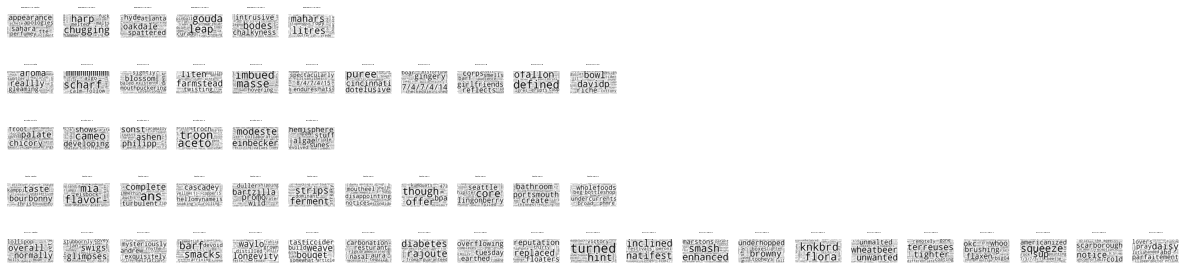

In [101]:
dupa(model)